In [1]:
import sys
import os
from ml4cvd.arguments import parse_args
from ml4cvd.recipes import run
import h5py
import numpy as np
import matplotlib
# font = {'family' : 'Arial',
#         'size'   : 30}
# matplotlib.rc('font', **font)
import matplotlib.pyplot as plt
from typing import List, Dict, Callable
from collections import defaultdict
import pandas as pd

from ml4cvd.arguments import _get_tmap
from ml4cvd.TensorMap import TensorMap
from ml4cvd.tensor_from_file import TMAPS

import numpy as np
USER = 'pdiachil'
HOME_PATH = '/home/' + USER

/usr/local/lib/python3.6/dist-packages/apache_beam/__init__.py:84: UserWarning: Running the Apache Beam SDK on Python 3 is not yet fully supported. You may encounter buggy behavior or missing features.
  'Running the Apache Beam SDK on Python 3 is not yet fully supported. '
Using TensorFlow backend.


In [2]:
# sys.argv = ['tensorize',
#             '--mode', 'tensorize_ludb',
#             '--xml_folder', f'{HOME_PATH}/ludb/',
#             '--output_folder', f'{HOME_PATH}/ludb_tensors/',
#             '--tensors', f'{HOME_PATH}/ludb_tensors/',
#             '--min_sample_id', '1', 
#             '--max_sample_id', '201'
#            ]
# args = parse_args()
# run(args)

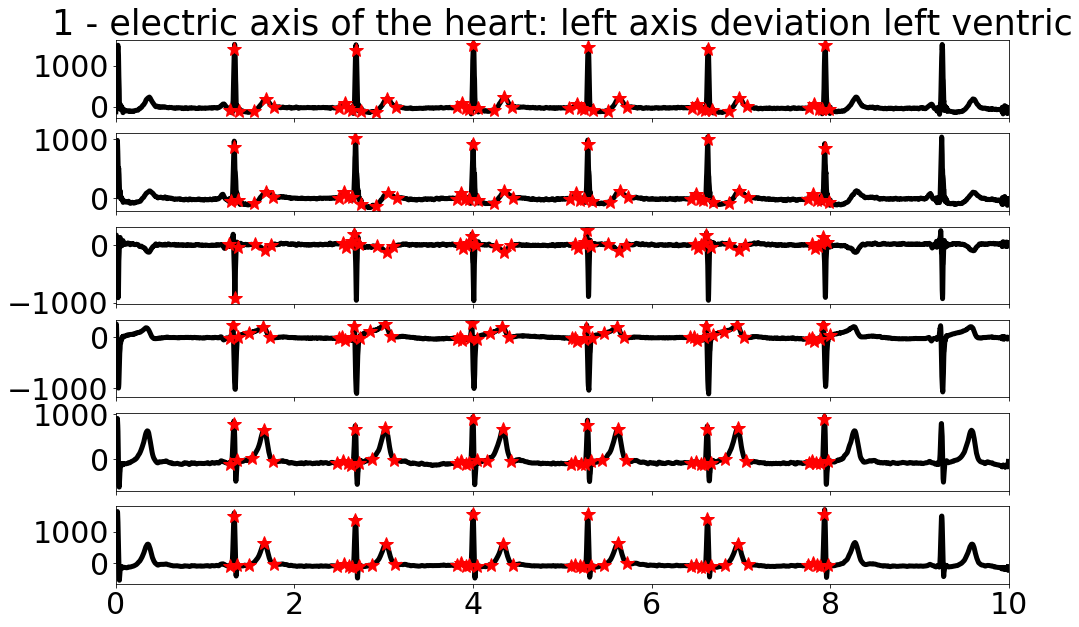

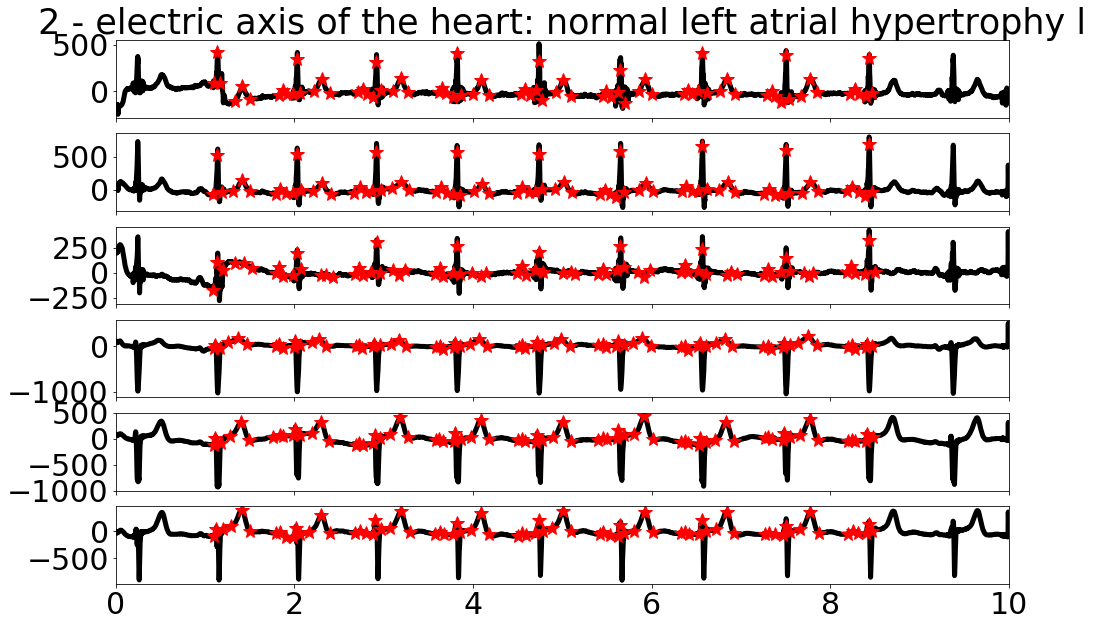

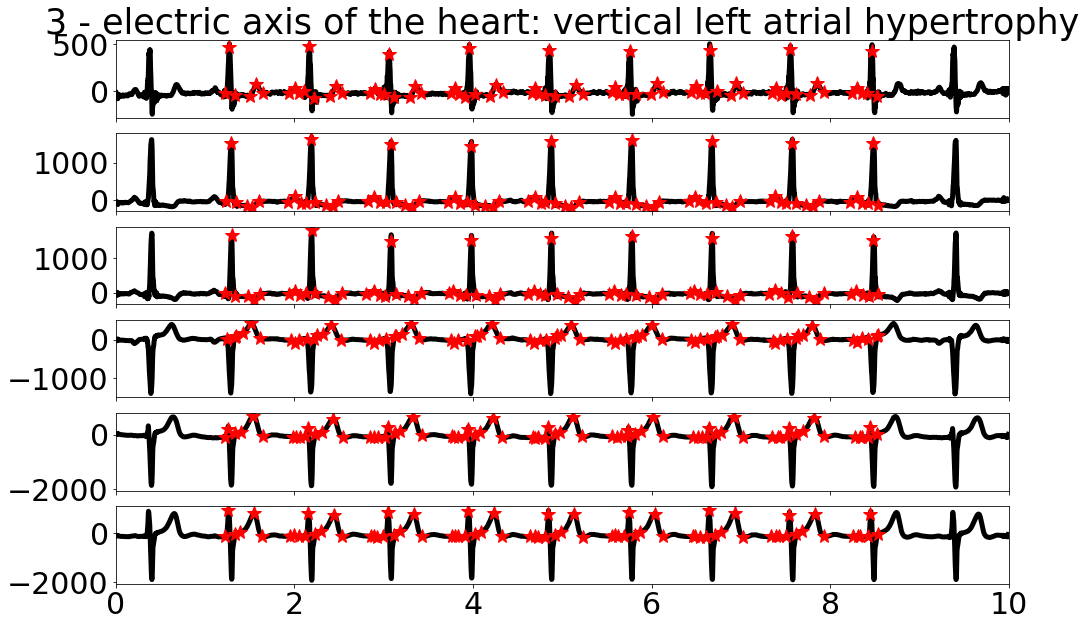

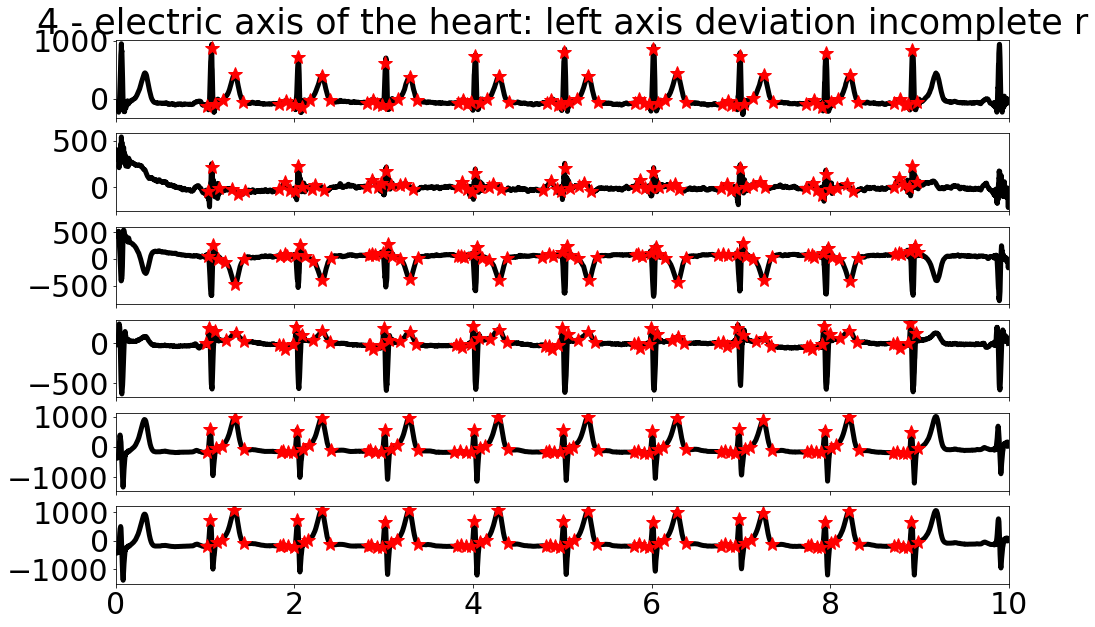

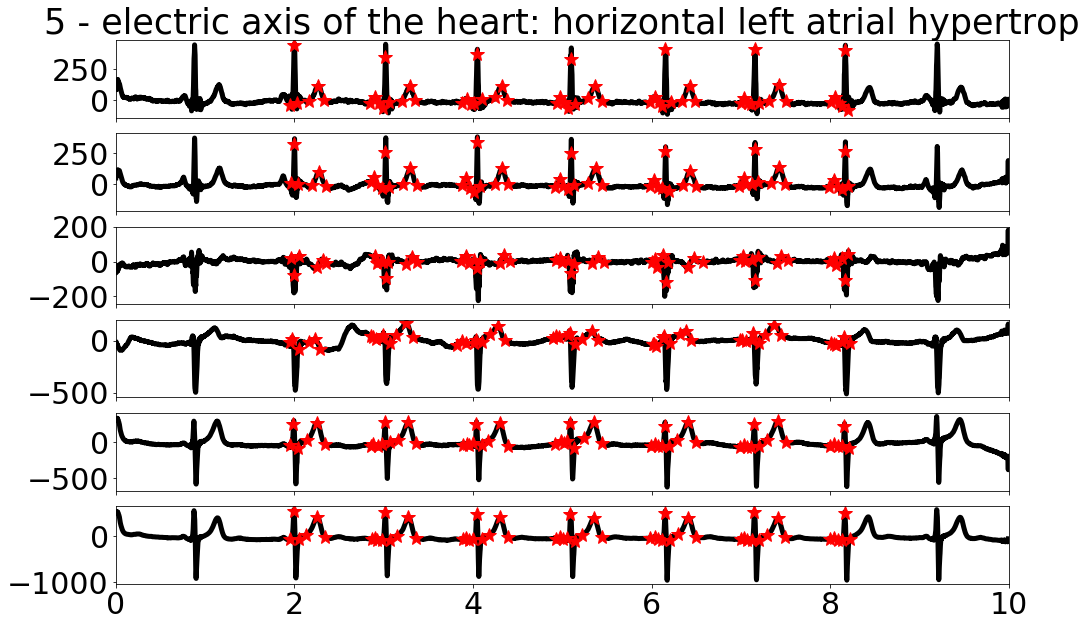

In [3]:
%matplotlib inline

ECG_REST_LUDB_LEADS =  {'i': 0, 'ii': 1, 'iii': 2, 'v1': 3, 'v2': 4, 'v3': 5,
                        'v4': 6, 'v5': 7, 'v6': 8, 'avf': 9, 'avl': 10, 'avr': 11}
ECG_REST_LUDB_LEADS =  {'i': 0, 'ii': 1, 'iii': 2, 'v1': 3, 'v2': 4, 'v3': 5}

for i in range(1, 200):
    with h5py.File(f'{HOME_PATH}/ludb_tensors/{i}.hd5', 'r') as hd5:
        f, ax = plt.subplots(len(ECG_REST_LUDB_LEADS), 1)
        f.set_size_inches(16, 10)
        for lead in ECG_REST_LUDB_LEADS:
            ann = np.array(hd5[f'ecg_rest_annotation/annotation_{lead}'])
            data = np.array(hd5[f'ecg_rest/strip_{lead}'])
            ax[ECG_REST_LUDB_LEADS[lead]].plot(data, 'k', linewidth=5)
            ax[ECG_REST_LUDB_LEADS[lead]].plot(ann, data[ann], 'r*', markersize=15)
            ax[ECG_REST_LUDB_LEADS[lead]].set_xticklabels([])
            ax[ECG_REST_LUDB_LEADS[lead]].set_xticks([0, 1000, 2000, 3000, 4000, 5000])
            ax[ECG_REST_LUDB_LEADS[lead]].set_xlim([0, 5000])
            ax[ECG_REST_LUDB_LEADS[lead]].tick_params(labelsize=30)
        ax[ECG_REST_LUDB_LEADS[lead]].set_xticklabels(['0', '2', '4', '6', '8', '10'])
        ax[0].set_title(str(i) + ' - ' + hd5['ecg_rest_text'][()][0][:60], size=35)
        plt.tight_layout
        f.savefig(f'/home/pdiachil/ludb_output/annotation_ludb_{i}.png')
    if i == 5:
        break

In [4]:
def annotation_to_segmentation(data, ann, shape = (5000,)):
    cycle = ['QR', 'RS', 'ST1', 'T1T2', 'T2T3', 'T3P1', 'P1P2', 'P2P3', 'P3Q']
    parsed_data = np.zeros(shape)
    parsed_range = ann[-1] - ann[0]
    parsed_data[:parsed_range] = data[ann[0]:ann[-1]]
    segmented_data = np.zeros(shape, dtype=np.int)
    ic = 0
    for ia in range(len(ann)-1):
        segmented_data[ann[ia]-ann[0]:ann[ia+1]-ann[0]] = ic
        ic += 1
        if ic == len(cycle):
            ic = 0
    return parsed_data, segmented_data      

In [5]:
import matplotlib

segments = {0 : 'background', 1: 'qrs', 2: 'st', 3: 't', 4: 'tp', 5: 'p', 6: 'pq'}
colors = {'background': 'black', 'qrs': 'red', 'st': 'blue', 't': 'cyan', 'tp': 'magenta', 'p': 'green', 'pq': 'yellow'}

cmap = matplotlib.cm.get_cmap('Pastel1')
cmap_float = np.linspace(0.0, 1.0, 7)

colors = {'background': cmap(cmap_float[0]), 'qrs': cmap(cmap_float[1]), 'st': cmap(cmap_float[2]), 't': cmap(cmap_float[3]), 
          'tp': cmap(cmap_float[4]), 'p': cmap(cmap_float[5]), 'pq': cmap(cmap_float[6])}

def plot_segmented_ecg(input_tensor, output_tensor):
    for ecg in range(input_tensor.shape[0]):
        f, ax = plt.subplots(8,1)
        f.set_size_inches(16, 9)           
        
        for lead in range(input_tensor.shape[2]):
            ax[lead].plot(input_tensor[ecg, :, lead, 0])
            ax[lead].set_xlim([0, input_tensor.shape[1]])
            segmented = np.argmax(output_tensor[ecg, :, lead, :], axis=1) 
            change_indices = np.where(segmented[:-1] != segmented[1:])[0]
            previous_change_index = 0
            for change_index in change_indices:
                ax[lead].axvspan(previous_change_index, change_index, 
                                 facecolor=colors[segments[segmented[change_index]]],
                                 alpha=1.0)
                previous_change_index = change_index
                previous_segment = segmented[previous_change_index]                                 
        break

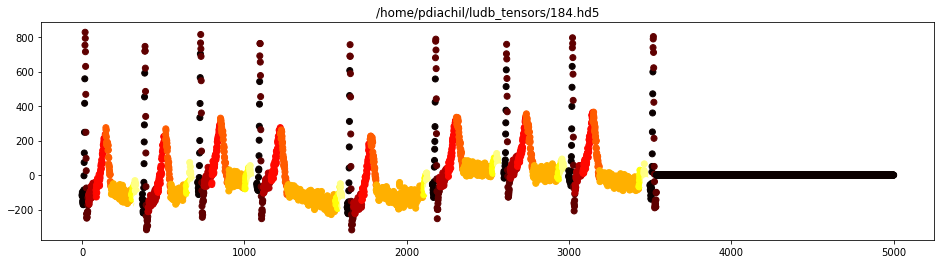

In [6]:
import glob
from matplotlib import cm
hd5_paths = glob.glob(f'{HOME_PATH}/ludb_tensors/*.hd5')
for hd5_path in hd5_paths:
    with h5py.File(hd5_path, 'r') as hd5:        
        ann = np.array(hd5['ecg_rest_annotation/annotation_i'])
        data = np.array(hd5['ecg_rest/strip_i'])
        parsed, segmented = annotation_to_segmentation(data, ann)
        f, ax = plt.subplots()
        f.set_size_inches(16, 4)
        ax.scatter(range(len(parsed)), parsed, c=cm.hot(segmented/8.0))
        ax.set_title(hd5_path)
        
    break

In [7]:
import glob
from ml4cvd.arguments import _get_tmap
hd5_paths = glob.glob(f'{HOME_PATH}/ludb_tensors/*.hd5')
tm_data = _get_tmap('ecg_rest_ludb')
tm_segmentation = _get_tmap('ecg_rest_ludb_segmentation_weighted')
for hd5_path in hd5_paths:
    with h5py.File(hd5_path, 'r') as hd5:
        data = tm_data.tensor_from_file(tm_data, hd5)
        segmentation = tm_segmentation.tensor_from_file(tm_segmentation, hd5)
    break

In [8]:
# sys.argv = ['train',
#             '--mode', 'train',
#             '--output_folder', f'{HOME_PATH}/ludb_output/',
#             '--tensors', f'{HOME_PATH}/ludb_tensors/',
#             '--input_tensors', 'ecg_rest_ludb',
#             '--output_tensors', 'ecg_rest_ludb_segmentation_coarse',
#             '--id', 'test_ludb_segmentation_unet',
#             '--num_workers', '0',
#             '--u_connect',
#             '--inspect_model',
#             '--training_steps', '14',
#             '--validation_steps', '2',
#             '--test_steps', '2',
#             '--batch_size', '4',
#             '--epochs', '100'
#            ]
# args = parse_args()
# run(args)

In [9]:
def tmaps_by_sample_id(tensor_folder: str, sample_id: str, tmaps: List[TensorMap], dependent_tmap):
    path = os.path.join(tensor_folder, sample_id + '.hd5')
    result_dict = defaultdict(lambda: None)
    dependents = defaultdict(lambda: None)
    if os.path.isfile(path):
            with h5py.File(path, 'r') as hd5:
                for tmap in tmaps:
                    try:
                        result_dict[tmap] = tmap.tensor_from_file(tmap, hd5, dependents)
                        for dependent in dependents:
                            result_dict[dependent] = np.array(dependents[dependent])
                    except (IndexError, KeyError, ValueError, OSError, RuntimeError):
                        continue
    return result_dict


def tmaps_with_properties(tensor_folder: str, tmap_properties: Dict[TensorMap, Callable[[np.ndarray], bool]], search_size=100, dependent_tmap=None):
    all_ids = [file.strip('.hd5') for file in sorted(os.listdir(tensor_folder))[:search_size]]
    results = map(lambda sample_id: tmaps_by_sample_id(tensor_folder, sample_id, tmap_properties.keys(), dependent_tmap), all_ids)
    return {
        sample_id: result
        for sample_id, result in zip(all_ids, results)
        if all(
            result[tmap] is not None and tmap_properties[tmap](result[tmap])
            for tmap in tmap_properties.keys()
        )
    }


def tmaps_with_properties_from_keys(tensor_folder: str, tmap_properties: Dict[str, Callable[[np.ndarray], bool]], search_size=100, dependent_tmap=None):
    return tmaps_with_properties(
        tensor_folder,
        {_get_tmap(key): prop for key, prop in tmap_properties.items()},
        search_size, dependent_tmap
    )

def tmap_dic_to_dic(tmap_dic):
    sample_id = []
    tmaps = []
    tmap_names = []
    tmap_subcols = []
    out_dic = {'sample_id': []}
        
    for i, entry in enumerate(tmap_dic):
        for t in tmap_dic[entry]:
            nsubcols = np.prod(t.shape)
            for n in range(nsubcols):
                out_dic[t.name + '_' + str(n)] = np.zeros(len(tmap_dic))
        break
    
    for i, entry in enumerate(tmap_dic):
        out_dic['sample_id'].append(entry)
        for t in tmap_dic[entry]:   
            nsubcols = np.prod(t.shape)
            for n in range(nsubcols):
                out_dic[t.name + '_' + str(n)][i] = tmap_dic[entry][t].ravel()[n]
    return out_dic

In [10]:
a = tmaps_by_sample_id('/home/pdiachil/ludb_tensors/', '1', [_get_tmap('ecg_rest_ludb')], _get_tmap('ecg_rest_ludb_segmentation_coarse'))

b = tmaps_with_properties_from_keys(
    '/home/pdiachil/ludb_tensors/', 
    {
        'ecg_rest_ludb': lambda x: True,
    },
    search_size = 20,
    dependent_tmap = _get_tmap('ecg_rest_ludb_segmentation_coarse')
)

In [11]:
dd = tmap_dic_to_dic(b)
df = pd.DataFrame(dd)
df

,sample_id,ecg_rest_ludb_0,ecg_rest_ludb_1,ecg_rest_ludb_2,ecg_rest_ludb_3,ecg_rest_ludb_4,ecg_rest_ludb_5,ecg_rest_ludb_6,ecg_rest_ludb_7,ecg_rest_ludb_8,...,ecg_rest_ludb_segmentation_279990,ecg_rest_ludb_segmentation_279991,ecg_rest_ludb_segmentation_279992,ecg_rest_ludb_segmentation_279993,ecg_rest_ludb_segmentation_279994,ecg_rest_ludb_segmentation_279995,ecg_rest_ludb_segmentation_279996,ecg_rest_ludb_segmentation_279997,ecg_rest_ludb_segmentation_279998,ecg_rest_ludb_segmentation_279999
0,1,-0.257201,-0.258774,1.018615,1.367758,0.762467,0.196454,-0.221103,-0.395959,-0.225290,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,10,0.014338,0.047999,-0.052040,-0.010940,-0.010816,-0.011023,-0.002370,-0.005723,0.014338,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100,-0.828180,-1.034469,-0.509978,0.732007,-0.417685,-0.831767,-1.027056,-1.084413,-0.828180,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,102,0.075794,0.040517,0.105357,0.176377,0.155188,0.059142,0.059092,-0.462268,0.075794,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,106,-0.012166,-0.789903,-0.142082,-0.327660,-0.384572,-0.104096,-0.168284,-0.018227,0.021314,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,107,-0.020639,0.070886,0.046281,0.125968,0.074692,0.289268,0.102106,-0.016381,-0.020639,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,108,-0.856611,-0.503959,-0.614234,-0.852642,-0.636599,-1.256624,0.396418,-1.509263,-1.071896,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,11,5.153403,6.113065,0.026509,1.405046,0.998663,3.824230,6.792101,8.301845,5.567950,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,113,-0.318333,0.017597,0.056281,0.140933,0.131058,-0.004939,-0.070599,-0.221635,-0.331093,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,119,-0.645545,-0.555905,0.053170,-0.440597,-0.345590,-0.552598,-0.489239,-0.675606,-0.645545,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [12]:
# cols = [f'ecg_rest_ludb_segmentation_{i}' for i in range(0, 40000, 2)]
# df[cols].apply(pd.Series.value_counts)

In [13]:
# 2900000.0 / df[cols].apply(pd.Series.value_counts).sum(axis=1)/20.390944

In [ ]:
sys.argv = ['train',
            '--mode', 'train',
            '--output_folder', f'{HOME_PATH}/ludb_output/',
            '--tensors', f'{HOME_PATH}/ludb_tensors/',
            '--input_tensors', 'ecg_rest_ludb',
            '--output_tensors', 'ecg_rest_ludb_segmentation_coarse',
            '--id', 'test_ludb_coarse_segmentation_roll_scale_shift_bylead_uconnect',
            '--num_workers', '0',
            '--u_connect', 
            '--inspect_model',
            '--training_steps', '15',
            '--validation_steps', '5',
            '--test_steps', '5',
            '--batch_size', '8',
            '--epochs', '400',
            '--patience', '40'            
           ]
args = parse_args()
run(args)

2020-01-31 10:32:35,151 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at /home/pdiachil/ludb_output/test_ludb_coarse_segmentation_roll_scale_shift_bylead_uconnect/log_2020-01-31_10-32_0.log.
2020-01-31 10:32:35,152 - arguments:207 - INFO - Command Line was:

./scripts/tf.sh train --mode train --output_folder /home/pdiachil/ludb_output/ --tensors /home/pdiachil/ludb_tensors/ --input_tensors ecg_rest_ludb --output_tensors ecg_rest_ludb_segmentation_coarse --id test_ludb_coarse_segmentation_roll_scale_shift_bylead_uconnect --num_workers 0 --u_connect --inspect_model --training_steps 15 --validation_steps 5 --test_steps 5 --batch_size 8 --epochs 400 --patience 40



2020-01-31 10:32:35,153 - arguments:208 - INFO - Total TensorMaps:396 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=8, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-cre

2020-01-31 10:32:36,122 - models:827 - INFO - Saving architecture diagram to:/home/pdiachil/ludb_output/test_ludb_coarse_segmentation_roll_scale_shift_bylead_uconnect/architecture_graph_test_ludb_coarse_segmentation_roll_scale_shift_bylead_uconnect.png
Epoch 1/1
2020-01-31 10:32:39,602 - tensor_generators:110 - INFO - Starting train_worker_0.
2020-01-31 10:32:39,603 - tensor_generators:110 - INFO - Starting validation_worker_0.
2020-01-31 10:32:39,606 - tensor_generators:234 - INFO - train_worker_0 initialized cache of size 0.129 GB.
2020-01-31 10:32:39,607 - tensor_generators:234 - INFO - validation_worker_0 initialized cache of size 0.044 GB.
2020-01-31 10:32:41,199 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 1:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	35 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they 

 9/15 [=================>............] - ETA: 2s - loss: 0.6748 - categorical_accuracy: 0.1224 - background_precision: 0.0000e+00 - qrs_precision: 0.2222 - st_precision: 0.0000e+00 - t_precision: 0.0029 - tp_precision: 0.0000e+00 - p_precision: 0.0000e+00 - pq_precision: 0.0000e+00 - background_recall: 0.0000e+00 - qrs_recall: 1.2949e-04 - st_recall: 0.0000e+00 - t_recall: 9.8913e-06 - tp_recall: 0.0000e+00 - p_recall: 0.0000e+00 - pq_recall: 0.0000e+002020-01-31 10:32:56,281 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 9:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	1.42 seconds elapsed.
11/15 [=====================>........] - ETA: 1s - loss: 0.6771 - categorical_accuracy: 0.1232 - background_precision: 0.0000e+00 - qrs_precision: 0.3636 

 2/15 [===>..........................] - ETA: 1s - loss: 0.6637 - categorical_accuracy: 0.1047 - background_precision: 0.0000e+00 - qrs_precision: 0.8711 - st_precision: 0.0000e+00 - t_precision: 0.0000e+00 - tp_precision: 0.0000e+00 - p_precision: 0.0000e+00 - pq_precision: 0.0000e+00 - background_recall: 0.0000e+00 - qrs_recall: 0.1053 - st_recall: 0.0000e+00 - t_recall: 0.0000e+00 - tp_recall: 0.0000e+00 - p_recall: 0.0000e+00 - pq_recall: 0.0000e+002020-01-31 10:33:06,390 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 12:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.06 seconds elapsed.
 4/15 [=======>......................] - ETA: 2s - loss: 0.6523 - categorical_accuracy: 0.1187 - background_precision: 0.0000e+00 - qrs_precision: 0.9321

15/15 [==============================] - 4s 235ms/step - loss: 0.6233 - categorical_accuracy: 0.1267 - background_precision: 0.0000e+00 - qrs_precision: 0.8845 - st_precision: 0.0000e+00 - t_precision: 0.0125 - tp_precision: 0.0000e+00 - p_precision: 0.0000e+00 - pq_precision: 0.0000e+00 - background_recall: 0.0000e+00 - qrs_recall: 0.3887 - st_recall: 0.0000e+00 - t_recall: 9.4753e-06 - tp_recall: 0.0000e+00 - p_recall: 0.0000e+00 - pq_recall: 0.0000e+00 - val_loss: 0.6188 - val_categorical_accuracy: 0.1250 - val_background_precision: 0.0000e+00 - val_qrs_precision: 0.8693 - val_st_precision: 0.0000e+00 - val_t_precision: 0.0000e+00 - val_tp_precision: 0.0000e+00 - val_p_precision: 0.0000e+00 - val_pq_precision: 0.0000e+00 - val_background_recall: 0.0000e+00 - val_qrs_recall: 0.4131 - val_st_recall: 0.0000e+00 - val_t_recall: 0.0000e+00 - val_tp_recall: 0.0000e+00 - val_p_recall: 0.0000e+00 - val_pq_recall: 0.0000e+00

Epoch 00006: val_loss improved from 0.61942 to 0.61883, saving mod

 5/15 [=========>....................] - ETA: 2s - loss: 0.5990 - categorical_accuracy: 0.1776 - background_precision: 0.0000e+00 - qrs_precision: 0.8616 - st_precision: 0.0000e+00 - t_precision: 0.0154 - tp_precision: 0.0000e+00 - p_precision: 0.0000e+00 - pq_precision: 0.0000e+00 - background_recall: 0.0000e+00 - qrs_recall: 0.5364 - st_recall: 0.0000e+00 - t_recall: 1.2581e-04 - tp_recall: 0.0000e+00 - p_recall: 0.0000e+00 - pq_recall: 0.0000e+00   2020-01-31 10:33:25,326 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 12:
	The following errors occurred:
		
	Generator looped & shuffled over 101 paths.
	101 tensors were presented.
	The cache holds 0 out of a possible 202 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.22 seconds elapsed.
15/15 [==============================] - 4s 233ms/step - loss: 0.5961 - categorical_accuracy: 0.2011 - background_precision: 0.0000e+00 - qrs_precision: 0.9


Epoch 00011: val_loss did not improve from 0.57112
Epoch 12/400
 5/15 [=========>....................] - ETA: 2s - loss: 0.5677 - categorical_accuracy: 0.3032 - background_precision: 0.0000e+00 - qrs_precision: 0.9108 - st_precision: 0.0000e+00 - t_precision: 0.7688 - tp_precision: 0.0000e+00 - p_precision: 0.0000e+00 - pq_precision: 0.0000e+00 - background_recall: 0.0000e+00 - qrs_recall: 0.7054 - st_recall: 0.0000e+00 - t_recall: 0.0940 - tp_recall: 0.0000e+00 - p_recall: 0.0000e+00 - pq_recall: 0.0000e+002020-01-31 10:33:36,017 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 22:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	1.56 seconds elapsed.
10/15 [===================>..........] - ETA: 1s - loss: 0.5571 - categorical_accuracy: 0.2974 -


Epoch 00014: val_loss did not improve from 0.52521
Epoch 15/400
 2/15 [===>..........................] - ETA: 2s - loss: 0.5354 - categorical_accuracy: 0.3663 - background_precision: 0.0000e+00 - qrs_precision: 0.9445 - st_precision: 0.0000e+00 - t_precision: 0.7760 - tp_precision: 0.0000e+00 - p_precision: 0.0000e+00 - pq_precision: 0.0000e+00 - background_recall: 0.0000e+00 - qrs_recall: 0.7595 - st_recall: 0.0000e+00 - t_recall: 0.2237 - tp_recall: 0.0000e+00 - p_recall: 0.0000e+00 - pq_recall: 0.0000e+002020-01-31 10:33:45,883 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 25:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.22 seconds elapsed.
 3/15 [=====>........................] - ETA: 2s - loss: 0.5332 - categorical_accuracy: 0.3616 -

15/15 [==============================] - 4s 276ms/step - loss: 0.5184 - categorical_accuracy: 0.4139 - background_precision: 0.0000e+00 - qrs_precision: 0.8671 - st_precision: 0.4695 - t_precision: 0.8774 - tp_precision: 0.0000e+00 - p_precision: 0.0000e+00 - pq_precision: 0.1154 - background_recall: 0.0000e+00 - qrs_recall: 0.7925 - st_recall: 0.0012 - t_recall: 0.2584 - tp_recall: 0.0000e+00 - p_recall: 0.0000e+00 - pq_recall: 0.0019 - val_loss: 0.5213 - val_categorical_accuracy: 0.3676 - val_background_precision: 0.0000e+00 - val_qrs_precision: 0.7911 - val_st_precision: 0.5168 - val_t_precision: 0.8147 - val_tp_precision: 0.0000e+00 - val_p_precision: 0.0000e+00 - val_pq_precision: 0.2821 - val_background_recall: 0.0000e+00 - val_qrs_recall: 0.7935 - val_st_recall: 0.0126 - val_t_recall: 0.2971 - val_tp_recall: 0.0000e+00 - val_p_recall: 0.0000e+00 - val_pq_recall: 0.0049

Epoch 00017: val_loss improved from 0.52521 to 0.52129, saving model to /home/pdiachil/ludb_output/test_ludb_c

15/15 [==============================] - 4s 238ms/step - loss: 0.4812 - categorical_accuracy: 0.4983 - background_precision: 0.0000e+00 - qrs_precision: 0.9099 - st_precision: 0.6495 - t_precision: 0.8632 - tp_precision: 0.0000e+00 - p_precision: 0.0691 - pq_precision: 0.3983 - background_recall: 0.0000e+00 - qrs_recall: 0.8022 - st_recall: 0.0965 - t_recall: 0.3508 - tp_recall: 0.0000e+00 - p_recall: 2.0688e-04 - pq_recall: 0.0628 - val_loss: 0.4684 - val_categorical_accuracy: 0.4344 - val_background_precision: 0.0000e+00 - val_qrs_precision: 0.8043 - val_st_precision: 0.6571 - val_t_precision: 0.8803 - val_tp_precision: 0.0000e+00 - val_p_precision: 0.0000e+00 - val_pq_precision: 0.3292 - val_background_recall: 0.0000e+00 - val_qrs_recall: 0.8653 - val_st_recall: 0.0900 - val_t_recall: 0.3884 - val_tp_recall: 0.0000e+00 - val_p_recall: 0.0000e+00 - val_pq_recall: 0.0841

Epoch 00020: val_loss improved from 0.49874 to 0.46841, saving model to /home/pdiachil/ludb_output/test_ludb_coars

 4/15 [=======>......................] - ETA: 3s - loss: 0.4524 - categorical_accuracy: 0.6252 - background_precision: 0.0000e+00 - qrs_precision: 0.9124 - st_precision: 0.6714 - t_precision: 0.8554 - tp_precision: 0.0000e+00 - p_precision: 0.0000e+00 - pq_precision: 0.4514 - background_recall: 0.0000e+00 - qrs_recall: 0.8173 - st_recall: 0.2225 - t_recall: 0.3794 - tp_recall: 0.0000e+00 - p_recall: 0.0000e+00 - pq_recall: 0.16302020-01-31 10:34:15,871 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 35:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	1.40 seconds elapsed.
 9/15 [=================>............] - ETA: 1s - loss: 0.4484 - categorical_accuracy: 0.6294 - background_precision: 0.0000e+00 - qrs_precision: 0.9072 - st_precision: 0.6975 

 2/15 [===>..........................] - ETA: 1s - loss: 0.4621 - categorical_accuracy: 0.6397 - background_precision: 0.0000e+00 - qrs_precision: 0.9342 - st_precision: 0.7050 - t_precision: 0.8334 - tp_precision: 0.9043 - p_precision: 0.0000e+00 - pq_precision: 0.4290 - background_recall: 0.0000e+00 - qrs_recall: 0.8038 - st_recall: 0.3097 - t_recall: 0.3192 - tp_recall: 0.0060 - p_recall: 0.0000e+00 - pq_recall: 0.25882020-01-31 10:34:25,775 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 32:
	The following errors occurred:
		
	Generator looped & shuffled over 101 paths.
	101 tensors were presented.
	The cache holds 0 out of a possible 202 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.78 seconds elapsed.
2020-01-31 10:34:25,832 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 38:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 


Epoch 00028: val_loss did not improve from 0.33122
Epoch 29/400
 4/15 [=======>......................] - ETA: 3s - loss: 0.3573 - categorical_accuracy: 0.6703 - background_precision: 0.9470 - qrs_precision: 0.8631 - st_precision: 0.7738 - t_precision: 0.8069 - tp_precision: 0.8155 - p_precision: 0.4632 - pq_precision: 0.5469 - background_recall: 0.7691 - qrs_recall: 0.8790 - st_recall: 0.3280 - t_recall: 0.4573 - tp_recall: 0.0168 - p_recall: 0.0040 - pq_recall: 0.44322020-01-31 10:34:37,349 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 42:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	1.55 seconds elapsed.
 7/15 [=============>................] - ETA: 2s - loss: 0.3581 - categorical_accuracy: 0.6889 - background_precision: 0.9504 - qrs_prec

 2/15 [===>..........................] - ETA: 2s - loss: 0.2959 - categorical_accuracy: 0.7586 - background_precision: 0.9998 - qrs_precision: 0.9210 - st_precision: 0.7955 - t_precision: 0.9275 - tp_precision: 0.9240 - p_precision: 0.4334 - pq_precision: 0.7420 - background_recall: 0.9623 - qrs_recall: 0.8903 - st_recall: 0.4613 - t_recall: 0.4908 - tp_recall: 0.1139 - p_recall: 0.0207 - pq_recall: 0.40402020-01-31 10:34:47,304 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 45:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.21 seconds elapsed.
13/15 [=========================>....] - ETA: 0s - loss: 0.3247 - categorical_accuracy: 0.7253 - background_precision: 0.9570 - qrs_precision: 0.9111 - st_precision: 0.7309 - t_precision: 0.8644 - tp_p


Epoch 00034: val_loss did not improve from 0.31181
Epoch 35/400
 4/15 [=======>......................] - ETA: 2s - loss: 0.3102 - categorical_accuracy: 0.7299 - background_precision: 0.9544 - qrs_precision: 0.9069 - st_precision: 0.6955 - t_precision: 0.8744 - tp_precision: 0.8798 - p_precision: 0.6016 - pq_precision: 0.6742 - background_recall: 0.8604 - qrs_recall: 0.8230 - st_recall: 0.4954 - t_recall: 0.5456 - tp_recall: 0.1718 - p_recall: 0.0418 - pq_recall: 0.48232020-01-31 10:34:59,031 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 49:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.21 seconds elapsed.
 5/15 [=========>....................] - ETA: 2s - loss: 0.3024 - categorical_accuracy: 0.7353 - background_precision: 0.9529 - qrs_prec


Epoch 00037: val_loss did not improve from 0.31181
Epoch 38/400
 2/15 [===>..........................] - ETA: 2s - loss: 0.2645 - categorical_accuracy: 0.7727 - background_precision: 0.9826 - qrs_precision: 0.9244 - st_precision: 0.7713 - t_precision: 0.8690 - tp_precision: 0.9138 - p_precision: 0.9339 - pq_precision: 0.6228 - background_recall: 0.9856 - qrs_recall: 0.9019 - st_recall: 0.4818 - t_recall: 0.4771 - tp_recall: 0.2058 - p_recall: 0.0542 - pq_recall: 0.65022020-01-31 10:35:08,679 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 52:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.22 seconds elapsed.
11/15 [=====================>........] - ETA: 0s - loss: 0.3066 - categorical_accuracy: 0.7388 - background_precision: 0.9747 - qrs_prec


Epoch 00040: val_loss did not improve from 0.31181
Epoch 41/400
 4/15 [=======>......................] - ETA: 2s - loss: 0.2792 - categorical_accuracy: 0.7340 - background_precision: 0.9444 - qrs_precision: 0.9205 - st_precision: 0.7227 - t_precision: 0.8944 - tp_precision: 0.8873 - p_precision: 0.7340 - pq_precision: 0.6171 - background_recall: 0.9559 - qrs_recall: 0.8960 - st_recall: 0.5609 - t_recall: 0.4943 - tp_recall: 0.1588 - p_recall: 0.0839 - pq_recall: 0.70222020-01-31 10:35:20,196 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 56:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.32 seconds elapsed.
 5/15 [=========>....................] - ETA: 2s - loss: 0.2793 - categorical_accuracy: 0.7333 - background_precision: 0.9473 - qrs_prec


Epoch 00043: val_loss improved from 0.30991 to 0.27410, saving model to /home/pdiachil/ludb_output/test_ludb_coarse_segmentation_roll_scale_shift_bylead_uconnect/test_ludb_coarse_segmentation_roll_scale_shift_bylead_uconnect.hd5
Epoch 44/400
 2/15 [===>..........................] - ETA: 2s - loss: 0.3009 - categorical_accuracy: 0.7232 - background_precision: 0.9266 - qrs_precision: 0.8797 - st_precision: 0.6713 - t_precision: 0.8114 - tp_precision: 0.9281 - p_precision: 0.6809 - pq_precision: 0.7157 - background_recall: 0.9398 - qrs_recall: 0.9387 - st_recall: 0.5366 - t_recall: 0.5248 - tp_recall: 0.1434 - p_recall: 0.0914 - pq_recall: 0.55082020-01-31 10:35:30,511 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 59:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they 


Epoch 00046: val_loss did not improve from 0.27410
Epoch 47/400
 3/15 [=====>........................] - ETA: 2s - loss: 0.2610 - categorical_accuracy: 0.7750 - background_precision: 0.9818 - qrs_precision: 0.9356 - st_precision: 0.6651 - t_precision: 0.9039 - tp_precision: 0.8553 - p_precision: 0.6626 - pq_precision: 0.7045 - background_recall: 0.9388 - qrs_recall: 0.8667 - st_recall: 0.5837 - t_recall: 0.4820 - tp_recall: 0.4135 - p_recall: 0.1995 - pq_recall: 0.69712020-01-31 10:35:41,777 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 57:
	The following errors occurred:
		
	Generator looped & shuffled over 101 paths.
	101 tensors were presented.
	The cache holds 0 out of a possible 202 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.79 seconds elapsed.
 4/15 [=======>......................] - ETA: 2s - loss: 0.2624 - categorical_accuracy: 0.7760 - background_precision: 0.9660 - qrs_precis

15/15 [==============================] - 4s 264ms/step - loss: 0.2727 - categorical_accuracy: 0.7718 - background_precision: 0.9595 - qrs_precision: 0.9076 - st_precision: 0.7503 - t_precision: 0.8727 - tp_precision: 0.9011 - p_precision: 0.5760 - pq_precision: 0.7157 - background_recall: 0.9456 - qrs_recall: 0.8701 - st_recall: 0.5513 - t_recall: 0.5816 - tp_recall: 0.3545 - p_recall: 0.1979 - pq_recall: 0.6172 - val_loss: 0.2650 - val_categorical_accuracy: 0.7691 - val_background_precision: 0.9961 - val_qrs_precision: 0.9050 - val_st_precision: 0.7350 - val_t_precision: 0.8809 - val_tp_precision: 0.9171 - val_p_precision: 0.6361 - val_pq_precision: 0.5420 - val_background_recall: 0.9735 - val_qrs_recall: 0.8432 - val_st_recall: 0.4370 - val_t_recall: 0.6787 - val_tp_recall: 0.3168 - val_p_recall: 0.1519 - val_pq_recall: 0.6519

Epoch 00049: val_loss did not improve from 0.24862
Epoch 50/400
 1/15 [=>............................] - ETA: 2s - loss: 0.5332 - categorical_accuracy: 0.6576

 1/15 [=>............................] - ETA: 2s - loss: 0.2600 - categorical_accuracy: 0.7583 - background_precision: 0.9451 - qrs_precision: 0.9416 - st_precision: 0.7694 - t_precision: 0.9140 - tp_precision: 0.8648 - p_precision: 0.4987 - pq_precision: 0.7465 - background_recall: 0.8484 - qrs_recall: 0.8653 - st_recall: 0.4885 - t_recall: 0.4708 - tp_recall: 0.5273 - p_recall: 0.3112 - pq_recall: 0.58372020-01-31 10:36:03,223 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 64:
	The following errors occurred:
		
	Generator looped & shuffled over 101 paths.
	101 tensors were presented.
	The cache holds 0 out of a possible 202 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.61 seconds elapsed.
 3/15 [=====>........................] - ETA: 2s - loss: 0.2542 - categorical_accuracy: 0.7777 - background_precision: 0.9486 - qrs_precision: 0.9439 - st_precision: 0.7547 - t_precision: 0.9054 - tp_pre


Epoch 00055: val_loss did not improve from 0.22484
Epoch 56/400
 1/15 [=>............................] - ETA: 1s - loss: 0.1931 - categorical_accuracy: 0.8109 - background_precision: 0.9459 - qrs_precision: 0.9083 - st_precision: 0.9083 - t_precision: 0.9011 - tp_precision: 0.9558 - p_precision: 0.6135 - pq_precision: 0.7138 - background_recall: 0.9906 - qrs_recall: 0.9443 - st_recall: 0.5134 - t_recall: 0.7188 - tp_recall: 0.3207 - p_recall: 0.4477 - pq_recall: 0.77022020-01-31 10:36:13,829 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 73:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.29 seconds elapsed.
 6/15 [===========>..................] - ETA: 2s - loss: 0.2352 - categorical_accuracy: 0.7882 - background_precision: 0.9249 - qrs_prec

15/15 [==============================] - 4s 238ms/step - loss: 0.2637 - categorical_accuracy: 0.7782 - background_precision: 0.9582 - qrs_precision: 0.9123 - st_precision: 0.7484 - t_precision: 0.8749 - tp_precision: 0.8871 - p_precision: 0.6027 - pq_precision: 0.7453 - background_recall: 0.9275 - qrs_recall: 0.8642 - st_recall: 0.5698 - t_recall: 0.5970 - tp_recall: 0.4506 - p_recall: 0.2781 - pq_recall: 0.6481 - val_loss: 0.2711 - val_categorical_accuracy: 0.7697 - val_background_precision: 0.9950 - val_qrs_precision: 0.9345 - val_st_precision: 0.7000 - val_t_precision: 0.8798 - val_tp_precision: 0.8629 - val_p_precision: 0.5300 - val_pq_precision: 0.7687 - val_background_recall: 0.8838 - val_qrs_recall: 0.8347 - val_st_recall: 0.5564 - val_t_recall: 0.5979 - val_tp_recall: 0.4652 - val_p_recall: 0.2587 - val_pq_recall: 0.6408

Epoch 00058: val_loss did not improve from 0.22484
Epoch 59/400
 3/15 [=====>........................] - ETA: 2s - loss: 0.2789 - categorical_accuracy: 0.7695


Epoch 00061: val_loss did not improve from 0.22484
Epoch 62/400
2020-01-31 10:36:34,937 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 80:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.26 seconds elapsed.
 5/15 [=========>....................] - ETA: 2s - loss: 0.2298 - categorical_accuracy: 0.7995 - background_precision: 0.9721 - qrs_precision: 0.9065 - st_precision: 0.7898 - t_precision: 0.9241 - tp_precision: 0.8838 - p_precision: 0.6298 - pq_precision: 0.7886 - background_recall: 0.9268 - qrs_recall: 0.9240 - st_recall: 0.5949 - t_recall: 0.5687 - tp_recall: 0.4789 - p_recall: 0.3395 - pq_recall: 0.69572020-01-31 10:36:36,392 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 75:
	The following errors occurred:
		
	G

15/15 [==============================] - 3s 229ms/step - loss: 0.2489 - categorical_accuracy: 0.7941 - background_precision: 0.9550 - qrs_precision: 0.9111 - st_precision: 0.7565 - t_precision: 0.8660 - tp_precision: 0.9013 - p_precision: 0.5826 - pq_precision: 0.7331 - background_recall: 0.9571 - qrs_recall: 0.8712 - st_recall: 0.5814 - t_recall: 0.6172 - tp_recall: 0.5180 - p_recall: 0.3431 - pq_recall: 0.6623 - val_loss: 0.2858 - val_categorical_accuracy: 0.7059 - val_background_precision: 0.9890 - val_qrs_precision: 0.9077 - val_st_precision: 0.5725 - val_t_precision: 0.7789 - val_tp_precision: 0.7819 - val_p_precision: 0.4191 - val_pq_precision: 0.7414 - val_background_recall: 0.8669 - val_qrs_recall: 0.8785 - val_st_recall: 0.6360 - val_t_recall: 0.6253 - val_tp_recall: 0.3042 - val_p_recall: 0.3147 - val_pq_recall: 0.5942

Epoch 00064: val_loss did not improve from 0.22484
Epoch 65/400
 3/15 [=====>........................] - ETA: 2s - loss: 0.2101 - categorical_accuracy: 0.8194


Epoch 00067: val_loss did not improve from 0.22289
Epoch 68/400
2020-01-31 10:36:56,669 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 87:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.81 seconds elapsed.
 4/15 [=======>......................] - ETA: 2s - loss: 0.2171 - categorical_accuracy: 0.8113 - background_precision: 0.9820 - qrs_precision: 0.8853 - st_precision: 0.7095 - t_precision: 0.9298 - tp_precision: 0.8670 - p_precision: 0.6711 - pq_precision: 0.7901 - background_recall: 0.9076 - qrs_recall: 0.9394 - st_recall: 0.6386 - t_recall: 0.7000 - tp_recall: 0.5467 - p_recall: 0.4171 - pq_recall: 0.70502020-01-31 10:36:57,636 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 82:
	The following errors occurred:
		
	G


Epoch 00070: val_loss did not improve from 0.21420
Epoch 71/400
 3/15 [=====>........................] - ETA: 2s - loss: 0.2871 - categorical_accuracy: 0.7707 - background_precision: 0.9495 - qrs_precision: 0.8555 - st_precision: 0.7110 - t_precision: 0.8194 - tp_precision: 0.9006 - p_precision: 0.6535 - pq_precision: 0.5854 - background_recall: 0.9848 - qrs_recall: 0.8390 - st_recall: 0.5507 - t_recall: 0.6109 - tp_recall: 0.4287 - p_recall: 0.3059 - pq_recall: 0.70582020-01-31 10:37:08,044 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 91:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.24 seconds elapsed.
 8/15 [===============>..............] - ETA: 1s - loss: 0.2455 - categorical_accuracy: 0.7982 - background_precision: 0.9635 - qrs_prec


Epoch 00073: val_loss improved from 0.21420 to 0.20625, saving model to /home/pdiachil/ludb_output/test_ludb_coarse_segmentation_roll_scale_shift_bylead_uconnect/test_ludb_coarse_segmentation_roll_scale_shift_bylead_uconnect.hd5
Epoch 74/400
 2/15 [===>..........................] - ETA: 2s - loss: 0.1825 - categorical_accuracy: 0.8431 - background_precision: 0.9344 - qrs_precision: 0.9006 - st_precision: 0.8021 - t_precision: 0.9478 - tp_precision: 0.9575 - p_precision: 0.6525 - pq_precision: 0.7876 - background_recall: 0.9884 - qrs_recall: 0.9387 - st_recall: 0.5881 - t_recall: 0.5989 - tp_recall: 0.6537 - p_recall: 0.5009 - pq_recall: 0.77902020-01-31 10:37:18,489 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 89:
	The following errors occurred:
		
	Generator looped & shuffled over 101 paths.
	101 tensors were presented.
	The cache holds 0 out of a possible 202 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they pr


Epoch 00076: val_loss did not improve from 0.20625
Epoch 77/400
 3/15 [=====>........................] - ETA: 2s - loss: 0.2191 - categorical_accuracy: 0.8132 - background_precision: 0.9838 - qrs_precision: 0.9374 - st_precision: 0.7663 - t_precision: 0.8494 - tp_precision: 0.8864 - p_precision: 0.6682 - pq_precision: 0.7589 - background_recall: 0.9408 - qrs_recall: 0.8566 - st_recall: 0.6535 - t_recall: 0.6822 - tp_recall: 0.6181 - p_recall: 0.4775 - pq_recall: 0.73112020-01-31 10:37:29,273 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 98:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.35 seconds elapsed.
 7/15 [=============>................] - ETA: 2s - loss: 0.2264 - categorical_accuracy: 0.8225 - background_precision: 0.9786 - qrs_prec


Epoch 00079: val_loss did not improve from 0.20625
Epoch 80/400
 4/15 [=======>......................] - ETA: 2s - loss: 0.2395 - categorical_accuracy: 0.8194 - background_precision: 0.9756 - qrs_precision: 0.8905 - st_precision: 0.7595 - t_precision: 0.8856 - tp_precision: 0.8969 - p_precision: 0.6816 - pq_precision: 0.6791 - background_recall: 0.9357 - qrs_recall: 0.8544 - st_recall: 0.6601 - t_recall: 0.6449 - tp_recall: 0.6632 - p_recall: 0.4361 - pq_recall: 0.73912020-01-31 10:37:40,418 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 102:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	1.49 seconds elapsed.
12/15 [=======================>......] - ETA: 0s - loss: 0.2239 - categorical_accuracy: 0.8225 - background_precision: 0.9729 - qrs_pre

 5/15 [=========>....................] - ETA: 2s - loss: 0.1933 - categorical_accuracy: 0.8309 - background_precision: 0.9747 - qrs_precision: 0.9212 - st_precision: 0.8086 - t_precision: 0.9012 - tp_precision: 0.9649 - p_precision: 0.7362 - pq_precision: 0.7102 - background_recall: 0.9604 - qrs_recall: 0.9061 - st_recall: 0.6542 - t_recall: 0.6923 - tp_recall: 0.5008 - p_recall: 0.4936 - pq_recall: 0.82082020-01-31 10:37:51,239 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 100:
	The following errors occurred:
		
	Generator looped & shuffled over 101 paths.
	101 tensors were presented.
	The cache holds 0 out of a possible 202 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.13 seconds elapsed.
15/15 [==============================] - 4s 238ms/step - loss: 0.2238 - categorical_accuracy: 0.8209 - background_precision: 0.9705 - qrs_precision: 0.9010 - st_precision: 0.7610 - t_precision: 0.8814 -

 4/15 [=======>......................] - ETA: 2s - loss: 0.2444 - categorical_accuracy: 0.8086 - background_precision: 0.9750 - qrs_precision: 0.9029 - st_precision: 0.8017 - t_precision: 0.8151 - tp_precision: 0.8903 - p_precision: 0.6523 - pq_precision: 0.7990 - background_recall: 0.9194 - qrs_recall: 0.8613 - st_recall: 0.6042 - t_recall: 0.7108 - tp_recall: 0.6391 - p_recall: 0.5306 - pq_recall: 0.66682020-01-31 10:38:01,738 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 109:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.23 seconds elapsed.
11/15 [=====================>........] - ETA: 0s - loss: 0.2334 - categorical_accuracy: 0.8121 - background_precision: 0.9633 - qrs_precision: 0.9150 - st_precision: 0.7446 - t_precision: 0.8693 - tp_

 4/15 [=======>......................] - ETA: 2s - loss: 0.1992 - categorical_accuracy: 0.8411 - background_precision: 0.9892 - qrs_precision: 0.9332 - st_precision: 0.6835 - t_precision: 0.9330 - tp_precision: 0.9254 - p_precision: 0.6945 - pq_precision: 0.7974 - background_recall: 0.9826 - qrs_recall: 0.8779 - st_recall: 0.6689 - t_recall: 0.6756 - tp_recall: 0.7084 - p_recall: 0.5342 - pq_recall: 0.71292020-01-31 10:38:12,412 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 107:
	The following errors occurred:
		
	Generator looped & shuffled over 101 paths.
	101 tensors were presented.
	The cache holds 0 out of a possible 202 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.89 seconds elapsed.
15/15 [==============================] - 4s 235ms/step - loss: 0.2172 - categorical_accuracy: 0.8197 - background_precision: 0.9709 - qrs_precision: 0.9165 - st_precision: 0.7350 - t_precision: 0.8937 -

 4/15 [=======>......................] - ETA: 2s - loss: 0.1937 - categorical_accuracy: 0.8451 - background_precision: 0.9775 - qrs_precision: 0.9385 - st_precision: 0.7829 - t_precision: 0.8903 - tp_precision: 0.9179 - p_precision: 0.7405 - pq_precision: 0.7448 - background_recall: 0.9869 - qrs_recall: 0.8572 - st_recall: 0.6568 - t_recall: 0.6223 - tp_recall: 0.7514 - p_recall: 0.4730 - pq_recall: 0.75422020-01-31 10:38:23,046 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 116:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.40 seconds elapsed.
 9/15 [=================>............] - ETA: 1s - loss: 0.2003 - categorical_accuracy: 0.8333 - background_precision: 0.9705 - qrs_precision: 0.9285 - st_precision: 0.7734 - t_precision: 0.8718 - tp_

2020-01-31 10:38:32,982 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 114:
	The following errors occurred:
		
	Generator looped & shuffled over 101 paths.
	101 tensors were presented.
	The cache holds 0 out of a possible 202 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.66 seconds elapsed.
14/15 [===========================>..] - ETA: 0s - loss: 0.2041 - categorical_accuracy: 0.8337 - background_precision: 0.9656 - qrs_precision: 0.9182 - st_precision: 0.7646 - t_precision: 0.8749 - tp_precision: 0.9142 - p_precision: 0.6805 - pq_precision: 0.7515 - background_recall: 0.9532 - qrs_recall: 0.8753 - st_recall: 0.6504 - t_recall: 0.7063 - tp_recall: 0.7068 - p_recall: 0.5789 - pq_recall: 0.72582020-01-31 10:38:35,541 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 115:
	The following errors occurred:
		
	Generator looped & shuffled over 101 paths.
	101 tensors were pres

 4/15 [=======>......................] - ETA: 2s - loss: 0.2698 - categorical_accuracy: 0.7724 - background_precision: 0.9589 - qrs_precision: 0.8843 - st_precision: 0.7063 - t_precision: 0.8365 - tp_precision: 0.9235 - p_precision: 0.6243 - pq_precision: 0.7349 - background_recall: 0.9537 - qrs_recall: 0.8619 - st_recall: 0.6344 - t_recall: 0.6120 - tp_recall: 0.4825 - p_recall: 0.5127 - pq_recall: 0.59132020-01-31 10:38:44,154 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 123:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.49 seconds elapsed.
 7/15 [=============>................] - ETA: 2s - loss: 0.2498 - categorical_accuracy: 0.7920 - background_precision: 0.9669 - qrs_precision: 0.9081 - st_precision: 0.7481 - t_precision: 0.8616 - tp_

 2/15 [===>..........................] - ETA: 2s - loss: 0.1855 - categorical_accuracy: 0.8421 - background_precision: 0.9709 - qrs_precision: 0.8886 - st_precision: 0.8443 - t_precision: 0.9230 - tp_precision: 0.9683 - p_precision: 0.6680 - pq_precision: 0.7298 - background_recall: 0.9809 - qrs_recall: 0.9259 - st_recall: 0.6961 - t_recall: 0.6649 - tp_recall: 0.6289 - p_recall: 0.6690 - pq_recall: 0.81482020-01-31 10:38:54,145 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 126:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.40 seconds elapsed.
13/15 [=========================>....] - ETA: 0s - loss: 0.2108 - categorical_accuracy: 0.8273 - background_precision: 0.9732 - qrs_precision: 0.9109 - st_precision: 0.7874 - t_precision: 0.8918 - tp_

 3/15 [=====>........................] - ETA: 3s - loss: 0.2001 - categorical_accuracy: 0.8581 - background_precision: 0.9862 - qrs_precision: 0.8884 - st_precision: 0.7516 - t_precision: 0.9016 - tp_precision: 0.9290 - p_precision: 0.7484 - pq_precision: 0.6938 - background_recall: 0.9817 - qrs_recall: 0.8304 - st_recall: 0.6520 - t_recall: 0.7420 - tp_recall: 0.7779 - p_recall: 0.6213 - pq_recall: 0.77682020-01-31 10:39:05,775 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 130:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.30 seconds elapsed.
 6/15 [===========>..................] - ETA: 2s - loss: 0.1982 - categorical_accuracy: 0.8361 - background_precision: 0.9842 - qrs_precision: 0.9189 - st_precision: 0.7219 - t_precision: 0.8886 - tp_

 1/15 [=>............................] - ETA: 2s - loss: 0.1390 - categorical_accuracy: 0.9018 - background_precision: 0.9956 - qrs_precision: 0.9321 - st_precision: 0.8359 - t_precision: 0.9335 - tp_precision: 0.9505 - p_precision: 0.7444 - pq_precision: 0.8169 - background_recall: 0.9915 - qrs_recall: 0.9189 - st_recall: 0.7002 - t_recall: 0.7890 - tp_recall: 0.8393 - p_recall: 0.7795 - pq_recall: 0.80542020-01-31 10:39:15,707 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 133:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.28 seconds elapsed.
12/15 [=======================>......] - ETA: 0s - loss: 0.1908 - categorical_accuracy: 0.8421 - background_precision: 0.9634 - qrs_precision: 0.9243 - st_precision: 0.7758 - t_precision: 0.8709 - tp_


Epoch 00109: val_loss did not improve from 0.17535
Epoch 110/400
 3/15 [=====>........................] - ETA: 2s - loss: 0.1813 - categorical_accuracy: 0.8443 - background_precision: 0.9655 - qrs_precision: 0.9496 - st_precision: 0.7620 - t_precision: 0.9022 - tp_precision: 0.9240 - p_precision: 0.6794 - pq_precision: 0.7648 - background_recall: 0.9863 - qrs_recall: 0.8526 - st_recall: 0.7068 - t_recall: 0.6186 - tp_recall: 0.7302 - p_recall: 0.7058 - pq_recall: 0.73732020-01-31 10:39:27,217 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 137:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.37 seconds elapsed.
 5/15 [=========>....................] - ETA: 2s - loss: 0.1949 - categorical_accuracy: 0.8340 - background_precision: 0.9642 - qrs_pr

 1/15 [=>............................] - ETA: 2s - loss: 0.4241 - categorical_accuracy: 0.7660 - background_precision: 0.8837 - qrs_precision: 0.8285 - st_precision: 0.7331 - t_precision: 0.7277 - tp_precision: 0.8389 - p_precision: 0.6009 - pq_precision: 0.6578 - background_recall: 0.8821 - qrs_recall: 0.7885 - st_recall: 0.6177 - t_recall: 0.5647 - tp_recall: 0.6543 - p_recall: 0.6081 - pq_recall: 0.68352020-01-31 10:39:36,800 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 140:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.26 seconds elapsed.
10/15 [===================>..........] - ETA: 1s - loss: 0.2237 - categorical_accuracy: 0.8243 - background_precision: 0.9599 - qrs_precision: 0.9248 - st_precision: 0.7501 - t_precision: 0.8634 - tp_


Epoch 00115: val_loss did not improve from 0.17535
Epoch 116/400
 3/15 [=====>........................] - ETA: 2s - loss: 0.2163 - categorical_accuracy: 0.8257 - background_precision: 0.9389 - qrs_precision: 0.9472 - st_precision: 0.8123 - t_precision: 0.8731 - tp_precision: 0.8729 - p_precision: 0.6352 - pq_precision: 0.7056 - background_recall: 0.9428 - qrs_recall: 0.7791 - st_recall: 0.6171 - t_recall: 0.7349 - tp_recall: 0.7360 - p_recall: 0.7260 - pq_recall: 0.77182020-01-31 10:39:47,904 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 144:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.19 seconds elapsed.
2020-01-31 10:39:48,021 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 139:
	The following errors occurred:
		

 5/15 [=========>....................] - ETA: 2s - loss: 0.2013 - categorical_accuracy: 0.8364 - background_precision: 0.9629 - qrs_precision: 0.9110 - st_precision: 0.7991 - t_precision: 0.8391 - tp_precision: 0.9289 - p_precision: 0.7192 - pq_precision: 0.7630 - background_recall: 0.9569 - qrs_recall: 0.8851 - st_recall: 0.6547 - t_recall: 0.7016 - tp_recall: 0.7019 - p_recall: 0.6125 - pq_recall: 0.73762020-01-31 10:39:59,635 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 148:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	1.44 seconds elapsed.
 8/15 [===============>..............] - ETA: 1s - loss: 0.2075 - categorical_accuracy: 0.8301 - background_precision: 0.9605 - qrs_precision: 0.9103 - st_precision: 0.7936 - t_precision: 0.8561 - tp_

 3/15 [=====>........................] - ETA: 2s - loss: 0.2241 - categorical_accuracy: 0.8127 - background_precision: 0.9587 - qrs_precision: 0.8963 - st_precision: 0.7490 - t_precision: 0.9063 - tp_precision: 0.9105 - p_precision: 0.6101 - pq_precision: 0.6381 - background_recall: 0.9416 - qrs_recall: 0.8224 - st_recall: 0.7152 - t_recall: 0.6821 - tp_recall: 0.6598 - p_recall: 0.6940 - pq_recall: 0.71812020-01-31 10:40:09,602 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 151:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.26 seconds elapsed.
14/15 [===========================>..] - ETA: 0s - loss: 0.2018 - categorical_accuracy: 0.8341 - background_precision: 0.9707 - qrs_precision: 0.9179 - st_precision: 0.7622 - t_precision: 0.8787 - tp_


Epoch 00124: val_loss did not improve from 0.17535
Epoch 125/400
 4/15 [=======>......................] - ETA: 3s - loss: 0.1713 - categorical_accuracy: 0.8541 - background_precision: 0.9746 - qrs_precision: 0.9195 - st_precision: 0.7572 - t_precision: 0.8811 - tp_precision: 0.9541 - p_precision: 0.6903 - pq_precision: 0.7658 - background_recall: 0.9832 - qrs_recall: 0.8791 - st_recall: 0.7219 - t_recall: 0.7620 - tp_recall: 0.6846 - p_recall: 0.7364 - pq_recall: 0.74052020-01-31 10:40:21,058 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 155:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	1.55 seconds elapsed.
 7/15 [=============>................] - ETA: 2s - loss: 0.1780 - categorical_accuracy: 0.8487 - background_precision: 0.9717 - qrs_pr


Epoch 00127: val_loss did not improve from 0.17535
Epoch 128/400
 3/15 [=====>........................] - ETA: 2s - loss: 0.1686 - categorical_accuracy: 0.8433 - background_precision: 0.9540 - qrs_precision: 0.9497 - st_precision: 0.8203 - t_precision: 0.8933 - tp_precision: 0.9144 - p_precision: 0.6388 - pq_precision: 0.7670 - background_recall: 0.9858 - qrs_recall: 0.8746 - st_recall: 0.7095 - t_recall: 0.6480 - tp_recall: 0.7161 - p_recall: 0.7588 - pq_recall: 0.75672020-01-31 10:40:31,041 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 158:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.32 seconds elapsed.
12/15 [=======================>......] - ETA: 0s - loss: 0.1681 - categorical_accuracy: 0.8554 - background_precision: 0.9807 - qrs_pr


Epoch 00130: val_loss did not improve from 0.14678
Epoch 131/400
 4/15 [=======>......................] - ETA: 3s - loss: 0.2885 - categorical_accuracy: 0.7978 - background_precision: 0.9560 - qrs_precision: 0.8912 - st_precision: 0.7837 - t_precision: 0.8628 - tp_precision: 0.8159 - p_precision: 0.6583 - pq_precision: 0.7031 - background_recall: 0.8695 - qrs_recall: 0.8381 - st_recall: 0.6164 - t_recall: 0.7430 - tp_recall: 0.6805 - p_recall: 0.6565 - pq_recall: 0.70032020-01-31 10:40:42,422 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 162:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	1.51 seconds elapsed.
 5/15 [=========>....................] - ETA: 2s - loss: 0.2813 - categorical_accuracy: 0.8002 - background_precision: 0.9633 - qrs_pr

 2/15 [===>..........................] - ETA: 2s - loss: 0.1947 - categorical_accuracy: 0.8612 - background_precision: 0.9824 - qrs_precision: 0.8781 - st_precision: 0.7711 - t_precision: 0.8564 - tp_precision: 0.9355 - p_precision: 0.7288 - pq_precision: 0.7268 - background_recall: 0.9787 - qrs_recall: 0.8482 - st_recall: 0.6910 - t_recall: 0.7935 - tp_recall: 0.7815 - p_recall: 0.6549 - pq_recall: 0.72112020-01-31 10:40:52,331 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 165:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.29 seconds elapsed.
10/15 [===================>..........] - ETA: 1s - loss: 0.1891 - categorical_accuracy: 0.8421 - background_precision: 0.9776 - qrs_precision: 0.9249 - st_precision: 0.7475 - t_precision: 0.8789 - tp_

 4/15 [=======>......................] - ETA: 2s - loss: 0.1803 - categorical_accuracy: 0.8490 - background_precision: 0.9557 - qrs_precision: 0.9066 - st_precision: 0.7926 - t_precision: 0.8910 - tp_precision: 0.9287 - p_precision: 0.7230 - pq_precision: 0.6773 - background_recall: 0.9836 - qrs_recall: 0.8838 - st_recall: 0.6626 - t_recall: 0.6924 - tp_recall: 0.7687 - p_recall: 0.6329 - pq_recall: 0.79632020-01-31 10:41:04,586 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 164:
	The following errors occurred:
		
	Generator looped & shuffled over 101 paths.
	101 tensors were presented.
	The cache holds 0 out of a possible 202 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.11 seconds elapsed.
2020-01-31 10:41:04,728 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 169:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were p

 2/15 [===>..........................] - ETA: 2s - loss: 0.2380 - categorical_accuracy: 0.8390 - background_precision: 0.9991 - qrs_precision: 0.8655 - st_precision: 0.7291 - t_precision: 0.8431 - tp_precision: 0.9268 - p_precision: 0.6439 - pq_precision: 0.7077 - background_recall: 0.9885 - qrs_recall: 0.8078 - st_recall: 0.6058 - t_recall: 0.7557 - tp_recall: 0.7815 - p_recall: 0.6805 - pq_recall: 0.69542020-01-31 10:41:14,503 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 172:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.29 seconds elapsed.
 9/15 [=================>............] - ETA: 1s - loss: 0.1847 - categorical_accuracy: 0.8485 - background_precision: 0.9725 - qrs_precision: 0.9236 - st_precision: 0.7800 - t_precision: 0.8892 - tp_


Epoch 00142: val_loss did not improve from 0.13961
Epoch 143/400
 2/15 [===>..........................] - ETA: 2s - loss: 0.1193 - categorical_accuracy: 0.8971 - background_precision: 0.9998 - qrs_precision: 0.9565 - st_precision: 0.7413 - t_precision: 0.9304 - tp_precision: 0.9815 - p_precision: 0.7468 - pq_precision: 0.7762 - background_recall: 0.9794 - qrs_recall: 0.8813 - st_recall: 0.8523 - t_recall: 0.8020 - tp_recall: 0.7771 - p_recall: 0.8081 - pq_recall: 0.89572020-01-31 10:41:25,106 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 171:
	The following errors occurred:
		
	Generator looped & shuffled over 101 paths.
	101 tensors were presented.
	The cache holds 0 out of a possible 202 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.59 seconds elapsed.
 4/15 [=======>......................] - ETA: 2s - loss: 0.1692 - categorical_accuracy: 0.8594 - background_precision: 0.9740 - qrs_prec


Epoch 00145: val_loss did not improve from 0.13961
Epoch 146/400
 2/15 [===>..........................] - ETA: 2s - loss: 0.1647 - categorical_accuracy: 0.8657 - background_precision: 0.9906 - qrs_precision: 0.9448 - st_precision: 0.7278 - t_precision: 0.8906 - tp_precision: 0.9414 - p_precision: 0.7412 - pq_precision: 0.6905 - background_recall: 0.9828 - qrs_recall: 0.8773 - st_recall: 0.7149 - t_recall: 0.7865 - tp_recall: 0.7569 - p_recall: 0.6494 - pq_recall: 0.85752020-01-31 10:41:35,398 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 179:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.22 seconds elapsed.
 7/15 [=============>................] - ETA: 2s - loss: 0.1841 - categorical_accuracy: 0.8450 - background_precision: 0.9706 - qrs_pr

 3/15 [=====>........................] - ETA: 3s - loss: 0.1575 - categorical_accuracy: 0.8593 - background_precision: 0.9779 - qrs_precision: 0.9508 - st_precision: 0.7934 - t_precision: 0.8907 - tp_precision: 0.9229 - p_precision: 0.7465 - pq_precision: 0.7491 - background_recall: 0.9846 - qrs_recall: 0.8990 - st_recall: 0.7098 - t_recall: 0.6901 - tp_recall: 0.7723 - p_recall: 0.7350 - pq_recall: 0.82522020-01-31 10:41:46,586 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 183:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.27 seconds elapsed.
13/15 [=========================>....] - ETA: 0s - loss: 0.1761 - categorical_accuracy: 0.8496 - background_precision: 0.9772 - qrs_precision: 0.9242 - st_precision: 0.7648 - t_precision: 0.8735 - tp_

 5/15 [=========>....................] - ETA: 2s - loss: 0.1696 - categorical_accuracy: 0.8535 - background_precision: 0.9796 - qrs_precision: 0.9352 - st_precision: 0.7696 - t_precision: 0.8756 - tp_precision: 0.9287 - p_precision: 0.6813 - pq_precision: 0.7644 - background_recall: 0.9823 - qrs_recall: 0.8717 - st_recall: 0.6815 - t_recall: 0.6968 - tp_recall: 0.7622 - p_recall: 0.7394 - pq_recall: 0.78292020-01-31 10:41:58,099 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 182:
	The following errors occurred:
		
	Generator looped & shuffled over 101 paths.
	101 tensors were presented.
	The cache holds 0 out of a possible 202 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.01 seconds elapsed.
15/15 [==============================] - 3s 228ms/step - loss: 0.1856 - categorical_accuracy: 0.8418 - background_precision: 0.9794 - qrs_precision: 0.9201 - st_precision: 0.7579 - t_precision: 0.8645 -

 3/15 [=====>........................] - ETA: 2s - loss: 0.1517 - categorical_accuracy: 0.8640 - background_precision: 0.9815 - qrs_precision: 0.9475 - st_precision: 0.8023 - t_precision: 0.8994 - tp_precision: 0.9475 - p_precision: 0.7308 - pq_precision: 0.7223 - background_recall: 0.9802 - qrs_recall: 0.8907 - st_recall: 0.7608 - t_recall: 0.6994 - tp_recall: 0.7646 - p_recall: 0.7577 - pq_recall: 0.80922020-01-31 10:42:07,826 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 190:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.28 seconds elapsed.
11/15 [=====================>........] - ETA: 0s - loss: 0.1782 - categorical_accuracy: 0.8521 - background_precision: 0.9834 - qrs_precision: 0.9142 - st_precision: 0.7856 - t_precision: 0.8631 - tp_

 4/15 [=======>......................] - ETA: 2s - loss: 0.1547 - categorical_accuracy: 0.8623 - background_precision: 0.9867 - qrs_precision: 0.9352 - st_precision: 0.7776 - t_precision: 0.8822 - tp_precision: 0.9597 - p_precision: 0.7085 - pq_precision: 0.6804 - background_recall: 0.9856 - qrs_recall: 0.8884 - st_recall: 0.7301 - t_recall: 0.7265 - tp_recall: 0.7308 - p_recall: 0.7364 - pq_recall: 0.82242020-01-31 10:42:18,787 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 189:
	The following errors occurred:
		
	Generator looped & shuffled over 101 paths.
	101 tensors were presented.
	The cache holds 0 out of a possible 202 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.09 seconds elapsed.
14/15 [===========================>..] - ETA: 0s - loss: 0.1707 - categorical_accuracy: 0.8546 - background_precision: 0.9829 - qrs_precision: 0.9212 - st_precision: 0.7776 - t_precision: 0.8755 - tp_pr


Epoch 00160: val_loss did not improve from 0.13961
Epoch 161/400
 3/15 [=====>........................] - ETA: 2s - loss: 0.1436 - categorical_accuracy: 0.8682 - background_precision: 0.9821 - qrs_precision: 0.9536 - st_precision: 0.7724 - t_precision: 0.8492 - tp_precision: 0.9454 - p_precision: 0.7273 - pq_precision: 0.7331 - background_recall: 0.9823 - qrs_recall: 0.8614 - st_recall: 0.6837 - t_recall: 0.8127 - tp_recall: 0.7404 - p_recall: 0.8113 - pq_recall: 0.79732020-01-31 10:42:28,909 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 197:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.18 seconds elapsed.
 9/15 [=================>............] - ETA: 1s - loss: 0.1731 - categorical_accuracy: 0.8536 - background_precision: 0.9924 - qrs_pr

 3/15 [=====>........................] - ETA: 2s - loss: 0.1969 - categorical_accuracy: 0.8459 - background_precision: 0.9766 - qrs_precision: 0.9251 - st_precision: 0.8046 - t_precision: 0.8232 - tp_precision: 0.9182 - p_precision: 0.6710 - pq_precision: 0.7497 - background_recall: 0.9854 - qrs_recall: 0.8507 - st_recall: 0.6395 - t_recall: 0.7405 - tp_recall: 0.7626 - p_recall: 0.7430 - pq_recall: 0.68692020-01-31 10:42:39,155 - tensor_generators:301 - INFO - Worker train_worker_0 - In true epoch 196:
	The following errors occurred:
		
	Generator looped & shuffled over 101 paths.
	101 tensors were presented.
	The cache holds 0 out of a possible 202 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	2.62 seconds elapsed.
14/15 [===========================>..] - ETA: 0s - loss: 0.1782 - categorical_accuracy: 0.8503 - background_precision: 0.9823 - qrs_precision: 0.9213 - st_precision: 0.7794 - t_precision: 0.8519 - tp_pr

 3/15 [=====>........................] - ETA: 2s - loss: 0.1530 - categorical_accuracy: 0.8829 - background_precision: 0.9928 - qrs_precision: 0.9196 - st_precision: 0.7832 - t_precision: 0.8703 - tp_precision: 0.9401 - p_precision: 0.7867 - pq_precision: 0.7648 - background_recall: 0.9831 - qrs_recall: 0.8679 - st_recall: 0.7228 - t_recall: 0.7828 - tp_recall: 0.8384 - p_recall: 0.7594 - pq_recall: 0.79282020-01-31 10:42:49,951 - tensor_generators:301 - INFO - Worker validation_worker_0 - In true epoch 204:
	The following errors occurred:
		
	Generator looped & shuffled over 34 paths.
	34 tensors were presented.
	The cache holds 0 out of a possible 68 tensors and is 0% full.
	So far there have been 0 cache hits.
	0 paths were skipped because they previously failed.
	3.22 seconds elapsed.
 8/15 [===============>..............] - ETA: 1s - loss: 0.1562 - categorical_accuracy: 0.8635 - background_precision: 0.9854 - qrs_precision: 0.9292 - st_precision: 0.7880 - t_precision: 0.8867 - tp_

In [ ]:
b = tmaps_with_properties_from_keys(
    '/mnt/disks/ecg-rest-37k-tensors/2019-11-04/', 
    {
        'ecg_rest_random_lead': lambda x: True,
    },
    search_size = 20,
    dependent_tmap = _get_tmap('ecg_lead_detection')
)
dd = tmap_dic_to_dic(b)
df = pd.DataFrame(dd)
df

# Infer segmentation on rest

In [ ]:
# from ml4cvd.models import make_multimodal_multitask_model
# from ml4cvd.tensor_generators import test_train_valid_tensor_generators
# sys.argv = ['train',
#             '--mode', 'train',
#             '--output_folder', f'{HOME_PATH}/ukbb_output/',
#             '--tensors', f'/home/pdiachil/ludb_tensors/',
#             '--test_modulo', '0',
#             '--num_workers', '0',
#             '--valid_ratio', '0.0001',
#             '--test_ratio', '0.0001',
#             '--batch_size', '1',
#             '--input_tensors', 'ecg_rest_ludb',
#             '--output_tensors', 'ecg_rest_ludb_segmentation_coarse',
#             '--model_file', f'{HOME_PATH}/ludb_output/test_ludb_coarse_segmentation_roll_scale_shift_bylead/test_ludb_coarse_segmentation_roll_scale_shift_bylead.hd5',
#             '--id', 'ludb_coarse_segmentation_roll_scale_inferred_on_ecg_rest'
#            ]
# args = parse_args()
# model = make_multimodal_multitask_model(**args.__dict__)
# generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)

In [ ]:
import matplotlib

segments = {0 : 'background', 1: 'qrs', 2: 'st', 3: 't', 4: 'tp', 5: 'p', 6: 'pq'}
colors = {'background': 'black', 'qrs': 'red', 'st': 'blue', 't': 'cyan', 'tp': 'magenta', 'p': 'green', 'pq': 'yellow'}

cmap = matplotlib.cm.get_cmap('Pastel1')
cmap_float = np.linspace(0.0, 1.0, 7)

colors = {'background': cmap(cmap_float[0]), 'qrs': cmap(cmap_float[1]), 'st': cmap(cmap_float[2]), 't': cmap(cmap_float[3]), 
          'tp': cmap(cmap_float[4]), 'p': cmap(cmap_float[5]), 'pq': cmap(cmap_float[6])}

def plot_segmented_ecg(input_tensor, output_tensor):
    for ecg in range(input_tensor.shape[0]):
        f, ax = plt.subplots(8,1)
        f.set_size_inches(16, 12)           
        
        for lead in range(input_tensor.shape[2]):
            ax[lead].plot(input_tensor[ecg, :, lead, 0], linewidth=3)
            ax[lead].set_xlim([0, input_tensor.shape[1]])
            ax[lead].tick_params(labelsize=25)
            ax[lead].set_xticklabels([])
            ax[lead].set_yticklabels([])
            segmented = np.argmax(output_tensor[ecg, :, lead, :], axis=1) 
            change_indices = np.where(segmented[:-1] != segmented[1:])[0]
            previous_change_index = 0
            for change_index in change_indices:
                ax[lead].axvspan(previous_change_index, change_index, 
                                 facecolor=colors[segments[segmented[change_index]]],
                                 alpha=1.0)
                previous_change_index = change_index
                previous_segment = segmented[previous_change_index]    
        f.savefig('/home/pdiachil/')
        break

In [ ]:
for i in range(10):
    a, b = next(generate_train)
    input_tensor = a['input_ecg_rest_ludb_ecg_rest_ludb'].reshape((1, 5000, -1, 1))
    output_tensor = model.predict(input_tensor)
    plot_segmented_ecg(input_tensor, output_tensor)

In [ ]:
# from ml4cvd.models import make_multimodal_multitask_model
# from ml4cvd.tensor_generators import test_train_valid_tensor_generators
# sys.argv = ['train',
#             '--mode', 'train',
#             '--output_folder', f'{HOME_PATH}/ukbb_output/',
#             '--tensors', f'/mnt/disks/ecg-rest-37k-tensors/2019-11-04/',
#             '--test_modulo', '0',
#             '--num_workers', '0',
#             '--valid_ratio', '0.0001',
#             '--test_ratio', '0.0001',
#             '--batch_size', '1',
#             '--input_tensors', 'ecg_rest',
#             '--output_tensors', 'ecg_rest_ludb_segmentation_coarse',
#             '--model_file', f'{HOME_PATH}/ludb_output/test_ludb_coarse_segmentation_roll_scale_shift_bylead/test_ludb_coarse_segmentation_roll_scale_shift_bylead.hd5',
#             '--id', 'ludb_coarse_segmentation_roll_scale_inferred_on_ecg_rest'
#            ]
# args = parse_args()
# model = make_multimodal_multitask_model(**args.__dict__)
# generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)

In [ ]:
for i in range(20):
    a, b = next(generate_train)
    input_tensor = a['input_strip_ecg_rest'].reshape((1, 5000, -1, 1))
    output_tensor = model.predict(input_tensor)
    plot_segmented_ecg(input_tensor, output_tensor)

# Interval predictions for pretraining

In [ ]:
# sys.argv = ['train',
#             '--mode', 'train',
#             '--output_folder', f'{HOME_PATH}/ukbb_output/',
#             '--tensors', f'/mnt/disks/ecg-rest-37k-tensors/2019-11-04/',
#             '--input_tensors', 'ecg_rest',
#             '--output_tensors', 'ventricular-rate', 'qrs-duration', 'pp-interval', 'pq-interval', 'p-duration',
#             'qt-interval',
#             '--id', 'ecg_lead_detection_raw',
#             '--inspect_model',
#             '--training_steps', '810',
#             '--validation_steps', '115',
#             '--conv_z', '2',
#             '--test_steps', '230',
#             '--batch_size', '32',
#             '--epochs', '50',
#             '--patience', '12'            
#            ]
# args = parse_args()
# run(args)

# Lead detection

In [ ]:
# sys.argv = ['train',
#             '--mode', 'train',
#             '--output_folder', f'{HOME_PATH}/ukbb_output/',
#             '--tensors', f'/mnt/disks/ecg-rest-37k-tensors/2019-11-04/',
#             '--input_tensors', 'ecg_rest_random_lead',
#             '--output_tensors', 'ecg_lead_detection',
#             '--id', 'ecg_lead_detection_raw',
#             '--inspect_model',
#             '--training_steps', '810',
#             '--validation_steps', '115',
#             '--conv_z', '2',
#             '--test_steps', '230',
#             '--batch_size', '32',
#             '--epochs', '50',
#             '--patience', '12'            
#            ]
# args = parse_args()
# run(args)